In [2]:
%load_ext autoreload
%autoreload 2

# 2D Viewfactor Modelling tool
This notebook aims to create a unified 2D modelling tool for pvarrays. It can use as backend Sunpower's [pvfactors](https://github.com/SunPower/pvfactors) or NREL's [bifacialVF](https://github.com/NREL/bifacialvf). 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *

Setup some paths using pathlib

In [4]:
CWD = Path.cwd().parent
PATH = CWD/'data'
PATH.ls()

[PosixPath('/home/tc256760/Documents/bifacial_model_validation/data/ines_data.hdf')]

In [5]:
data = pd.read_hdf(PATH/'ines_data.hdf'); data.head()
data_small = data['18 Jul 2017']

## We provide input data every 5 minutes for a coerced year 2017.

This is a multiindex DataFrame, that has keys: 
- `meteo`: all input meteorological data
- `reference_cells`: ref_A is a front facing reference cell, the others are rear facing
- `sunpos`: the sunposition computed using PVLIB
- `tracker`: SAT computed using PVLIB, no backtrack

So one can do `data.meteo` to see the nested DataFrame 

In [6]:
data.meteo.head()

,temp_air,ghi,dni,dhi,pressure,humidity
date,,,,,,
2017-01-01 07:25:00,-2.18,0.0,0.0,0.0,998.25,95.9
2017-01-01 07:30:00,-2.21,0.0,0.0,0.0,998.28,95.8
2017-01-01 07:35:00,-2.20,0.0,0.0,0.0,998.22,96.0
2017-01-01 07:40:00,-2.20,0.0,0.0,0.0,998.22,96.3
2017-01-01 07:45:00,-2.18,0.0,0.0,0.0,998.25,96.2


In [7]:
data.reference_cells.head()

,ref_A,ref_A2,ref_B2,ref_E2
date,,,,
2017-01-01 07:25:00,0.0,0.0,0.0,0.0
2017-01-01 07:30:00,0.0,0.0,0.0,0.0
2017-01-01 07:35:00,0.0,0.0,0.0,0.0
2017-01-01 07:40:00,0.0,0.0,0.0,0.0
2017-01-01 07:45:00,0.0,0.0,0.0,0.0


## Define the PV plant
We define the PV plant geometry

In [8]:
from vf2d import system_def, merge_data

In [9]:
gps_data = {'Name':'Chambery', 'Latitude': 45.637001, 'Longitude': 5.881, 'Elevation': 235.0, 'TZ':+2}

In [17]:
pvarray_parameters = system_def(n_pvrows=2,
                                n_modules_vertically=2, #number of modules stacked together in each structure. Int.
                                module_size = (1.01, 1.69), #(width, height) this is a portrait module.
                                h_ground = 0.77, #height from the ground for the lower module, in meters.
                                surface_tilt = 30, #tilt of the installation, in degrees.
                                surface_azimuth = 180, #orientation of the axis, degrees from N, clockwise.
                                axis_azimuth = 90, #Direction facing the modules, degrees from N, clockwise.
                                albedo = 0.4, #Albedo from ground, can be constant or a value per timestep. Between 0 and 1.
                                rtr_spacing = 9.4, #row2row distance, in meters.
                                frontSurface = "glass", #glass or ARglass
                                backSurface = "glass",
                                back_measure_points = 12,
                                row_type='first', #where to recover the data, 'first', 'interior' or 'last'
                                gps_data=gps_data, # a dict containing 'Name', 'Latitute', 'Longitude', 'Elevation', 'TZ'
                               )

In [18]:
pvarray_parameters

{'pvfactors': {'n_pvrows': 2,
  'pvrow_height': 1.6149999999999998,
  'pvrow_width': 3.38,
  'tracking': False,
  'axis_azimuth': 90,
  'surface_tilt': 30,
  'surface_azimuth': 180,
  'albedo': 0.4,
  'gcr': 0.35957446808510635,
  'rho_front_pvrow': 0.04336154977936508,
  'rho_back_pvrow': 0.04336154977936508,
  'cut': {0: {'front': 1, 'back': 12}, 1: {'front': 1, 'back': 1}}},
 'bifacialvf': {'beta': 30,
  'sazm': 180,
  'C': 0.227810650887574,
  'rtr': 2.7810650887573964,
  'rowType': 'first',
  'transFactor': 0.013,
  'cellRows': 12,
  'PVfrontSurface': 'glass',
  'PVbackSurface': 'glass',
  'albedo': 0.4,
  'tracking': False},
 'gps_data': {'Name': 'Chambery',
  'Latitude': 45.637001,
  'Longitude': 5.881,
  'Elevation': 235.0,
  'TZ': 2}}

In [19]:
merged_data = merge_data(data_small.meteo, data_small.sunpos, pvarray_parameters['pvfactors'])

In [20]:
merged_data.head()

,ghi,dni,dhi,zenith,azimuth,elevation,surface_tilt,surface_azimuth,albedo
date,,,,,,,,,
2017-07-18 04:10:00,0.00,0.0,0.00,91.000000,59.572309,0.328591,30,180,0.4
2017-07-18 04:15:00,0.00,0.0,0.00,91.000000,60.460925,1.085116,30,180,0.4
2017-07-18 04:20:00,10.73,0.0,10.73,88.151694,61.344053,1.848306,30,180,0.4
2017-07-18 04:25:00,13.31,0.0,13.32,87.382059,62.221953,2.617941,30,180,0.4
2017-07-18 04:30:00,16.51,0.0,16.51,86.606199,63.094892,3.393801,30,180,0.4


In [21]:
from mypvfactors import *

In [26]:
pvfactors_out = pvfactors_engine_run(merged_data, pvarray_parameters['pvfactors'], parallel=0)

100%|██████████| 181/181 [00:03<00:00, 59.16it/s]


In [27]:
pvfactors_out.head()

,qinc_front,qinc_back_mean,qinc_back_0,qinc_back_1,qinc_back_2,qinc_back_3,qinc_back_4,qinc_back_5,qinc_back_6,qinc_back_7,qinc_back_8,qinc_back_9,qinc_back_10,qinc_back_11
date,,,,,,,,,,,,,,
2017-07-18 04:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-18 04:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-18 04:20:00,9.833055,4.623675,4.637289,4.634753,4.632236,4.629738,4.627257,4.624794,4.622350,4.619922,4.617513,4.615120,4.612745,4.610387
2017-07-18 04:25:00,12.209506,5.739735,5.756634,5.753487,5.750362,5.747260,5.744181,5.741124,5.738089,5.735076,5.732084,5.729114,5.726166,5.723239
2017-07-18 04:30:00,15.135242,7.131558,7.152492,7.148593,7.144723,7.140881,7.137066,7.133279,7.129519,7.125787,7.122082,7.118403,7.114750,7.111124


In [28]:
def run_simulation(data, pvarray_parameters, engine='pvfactors'):
    merged_data = merge_data(data.meteo, data.sunpos, pvarray_parameters['pvfactors'])
    if engine == 'pvfactors':   
        res = pvfactors_engine_run(merged_data, pvarray_parameters['pvfactors'], parallel=4)
    return res

In [29]:
run_simulation(data_small, pvarray_parameters, engine='pvfactors')

100%|██████████| 45/45 [00:02<00:00, 19.46it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 2.4335663318634033 sec


In [132]:
bvf = run_simulation(tmy[date], pvarray_parameters, engine='bifacialvf')

INFO:capetools.modelling.mypvfactors:Correcting 7 indexes, Total GHI discarded = 0.0
  0%|          | 0/103 [00:00<?, ?it/s]/home/tc256760/Apps/bifacialvf/bifacialvf/vf.py:640: RuntimeWarning: divide by zero encountered in double_scalars
  projectedX1 = PcellX - np.float64(PcellY) / math.tan(startElvDown);      # Projection of ElvDown to ground in -x direction
 21%|██▏       | 22/103 [00:00<00:00, 212.57it/s]

 
********* 
Running Simulation for TMY3:  Chambery
Location:   Chambery
Lat:  45.637001  Long:  5.881  Tz  2
Parameters: beta:  30   Sazm:  180   Height:  0.227810650887574   rtr separation:  2.7810650887573964   Row type:  first   Albedo:  0.4
Saving into output.csv
 
 


100%|██████████| 103/103 [00:00<00:00, 181.97it/s]

Finished


In [146]:
bvf.head()

,qinc_front,qinc_back_mean,qinc_back_0,qinc_back_1,qinc_back_2,qinc_back_3,qinc_back_4,qinc_back_5,qinc_back_6
date,,,,,,,,,
2017-01-05 07:50:00,9.426857,2.167058,2.431325,2.327278,2.208354,2.086532,2.017331,1.991539,2.107049
2017-01-05 07:55:00,17.856719,4.106390,4.625454,4.421836,4.190372,3.953737,3.810883,3.762127,3.980319
2017-01-05 08:00:00,35.786528,6.442600,7.139841,6.872166,6.577100,6.255975,6.009385,5.970994,6.272741
2017-01-05 08:05:00,42.836693,6.410073,6.953317,6.755572,6.543978,6.287617,6.010767,6.026368,6.292893
2017-01-05 08:10:00,32.265426,6.008992,6.611434,6.380805,6.121443,5.838361,5.623247,5.597389,5.890265


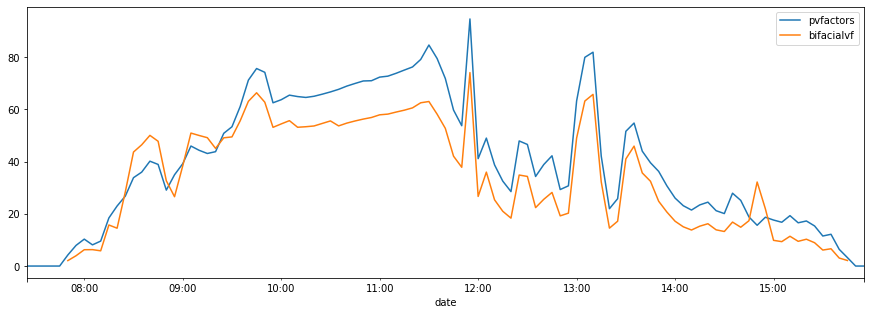

In [176]:
day = '5 Jan 2017'
pvfactors[day].qinc_back_3.plot(figsize=(15,5))
bvf[day].qinc_back_3.plot()
# tmy[day].meteo.ref_B2.plot(figsize=(15,5), color='r', dashes=(6,2))

plt.legend(['pvfactors', 'bifacialvf', 'B2'])

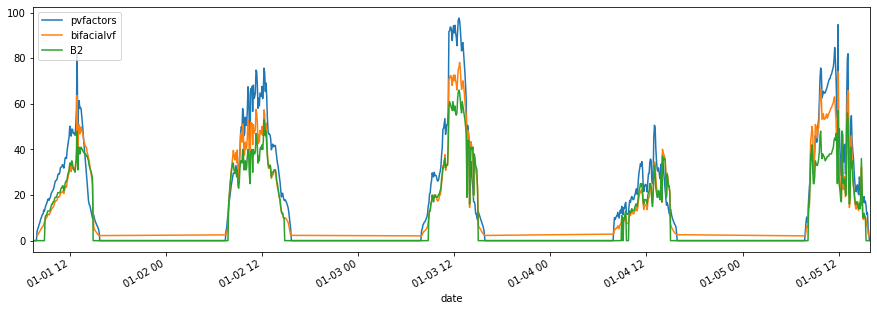

In [69]:
day = '01 Jan 2017'
day2 = '05 Jan 2017'
res[day:day2].qinc_back_3.plot(figsize=(15,5))
res2[day:day2].qinc_back_3.plot()
tmy[day:day2].meteo.ref_B2.plot()

plt.legend(['pvfactors', 'bifacialvf', 'B2'])

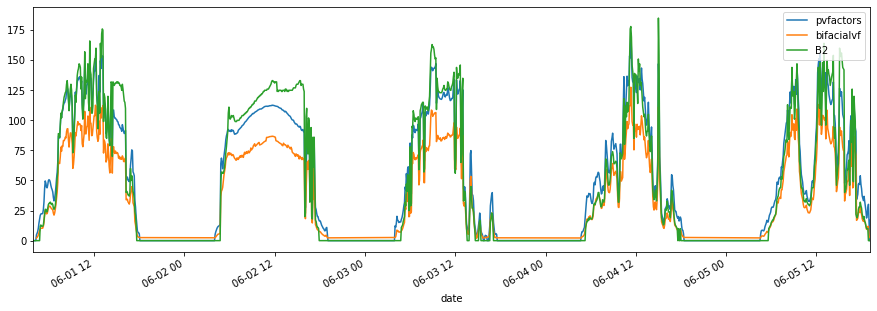

In [70]:
day = '01 Jun 2017'
day2 = '05 Jun 2017'
res[day:day2].qinc_back_3.plot(figsize=(15,5))
res2[day:day2].qinc_back_3.plot()
tmy[day:day2].meteo.ref_B2.plot()

plt.legend(['pvfactors', 'bifacialvf', 'B2'])

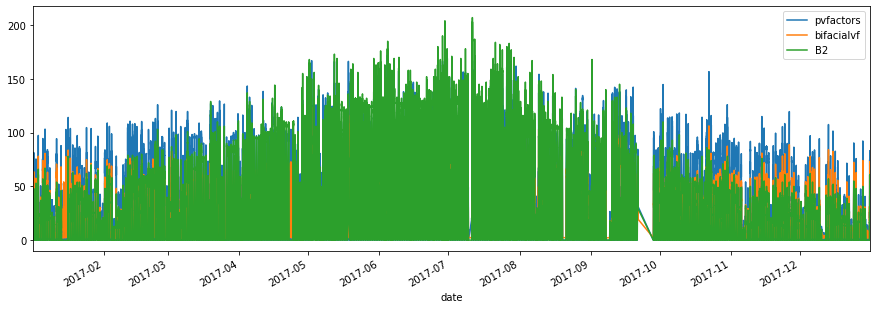

In [24]:
res.qinc_back_3.plot(figsize=(15,5))
res2.qinc_back_3.plot()
tmy.meteo.ref_B2.plot()
plt.legend(['pvfactors', 'bifacialvf', 'B2'])